In [93]:
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import ParameterGrid
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split



import prophet

warnings.filterwarnings('ignore')

In [92]:
# suppress the prophet logs
import logging

class SuppressFilter(logging.Filter):
    def filter(self, record):
        return False  

logger = logging.getLogger('cmdstanpy')
logger.addFilter(SuppressFilter())

# Prophet Multivariate

In [11]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/multivariate/enc_data_multi.csv')
esc = pd.read_csv('../../data/regional_datasets/multivariate/esc_data_multi.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/multivariate/mid_atlantic_data_multi.csv')
mountain = pd.read_csv('../../data/regional_datasets/multivariate/mountain_data_multi.csv')
new_england = pd.read_csv('../../data/regional_datasets/multivariate/new_england_data_multi.csv')
pacific = pd.read_csv('../../data/regional_datasets/multivariate/pacific_data_multi.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/multivariate/south_atlantic_data_multi.csv')
wnc = pd.read_csv('../../data/regional_datasets/multivariate/wnc_data_multi.csv')
wsc = pd.read_csv('../../data/regional_datasets/multivariate/wsc_data_multi.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df['date'] = pd.to_datetime(df['date'])
    df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
    df.sort_index(inplace=True)
    df.rename(columns={'date': 'ds', 'new_confirmed': 'y'}, inplace=True)


In [129]:
def build_multi_prophet(df, use_test=False, features=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    df = df.replace([np.nan], 0)

    if features is None:
        features = df.columns.drop(['ds', 'y', 'region', 'location_key'], errors='ignore')

    train_df, temp_test_df = train_test_split(df, test_size=0.15, shuffle=False)
    val, test  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    if use_test:
        _y = test['y']
        train = pd.concat([train_df, val])
    else:
        _y = val['y']
        train = train_df

    model = prophet.Prophet()
    for feature in features:
        model.add_regressor(feature, standardize=False)
    model = model.fit(train)

    # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
    pred = model.predict(test if use_test else val)
    pred_yhat = pred['yhat']
    pred_yhat[pred_yhat < 0] = 0

    # calculate metrics
    mae = mean_absolute_error(_y, pred_yhat)
    # mse = mean_squared_error(test_y, pred_yhat)
    rmse = mean_squared_error(_y, pred_yhat, squared=False)
    mase = mean_absolute_scaled_error(_y, pred_yhat, y_train=train['y'])

    print(f'MAE: {round(mae, 2)}')
    # print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Multivariate Prophet Predictions for {region} on {"Test" if use_test else "Validation"} Set')
        plt.plot(pred['ds'], _y, label='True')
        plt.plot(pred['ds'], pred_yhat, label='Predicted')
        # uncomment to show confidence interval
        # plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
        plt.legend() 
        plt.show()

Training model for East North Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 4869.72
RMSE: 6089.8
MASE: 0.58


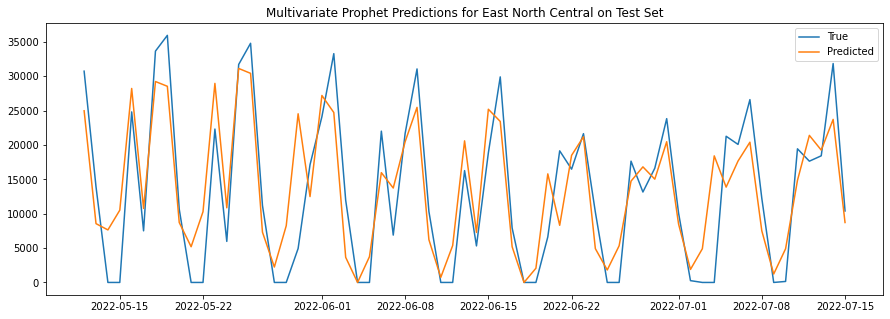


Training model for East South Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 2845.16
RMSE: 4050.92
MASE: 0.82


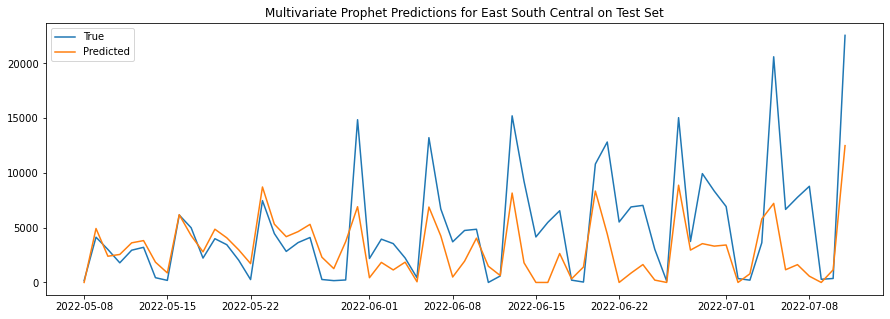


Training model for Mid-Atlantic...


Optimization terminated abnormally. Falling back to Newton.


MAE: 9852.71
RMSE: 12176.61
MASE: 4.41


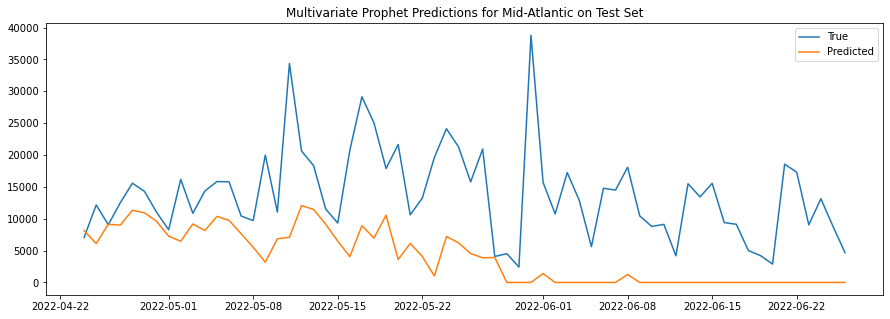


Training model for Mountain...


Optimization terminated abnormally. Falling back to Newton.


MAE: 5972.68
RMSE: 8088.68
MASE: 1.8


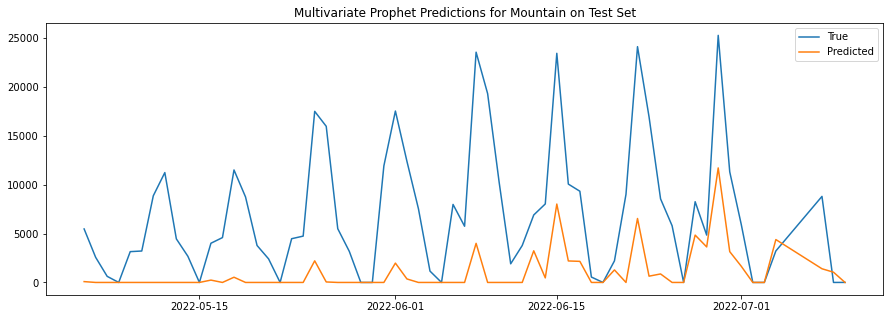


Training model for New England...


Optimization terminated abnormally. Falling back to Newton.


MAE: 4812.25
RMSE: 6515.24
MASE: 1.82


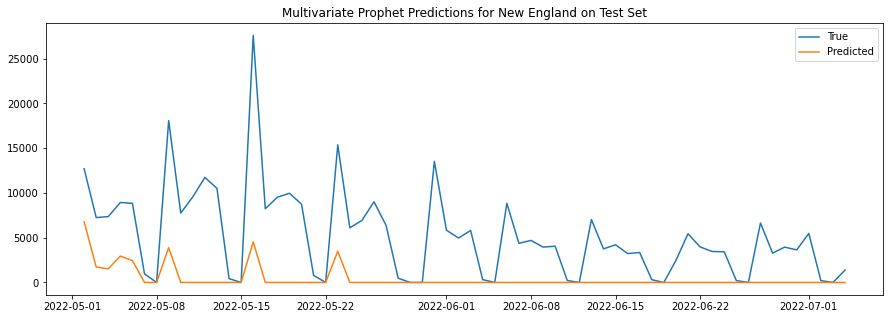


Training model for Pacific...


Optimization terminated abnormally. Falling back to Newton.


MAE: 10523.85
RMSE: 16465.2
MASE: 1.47


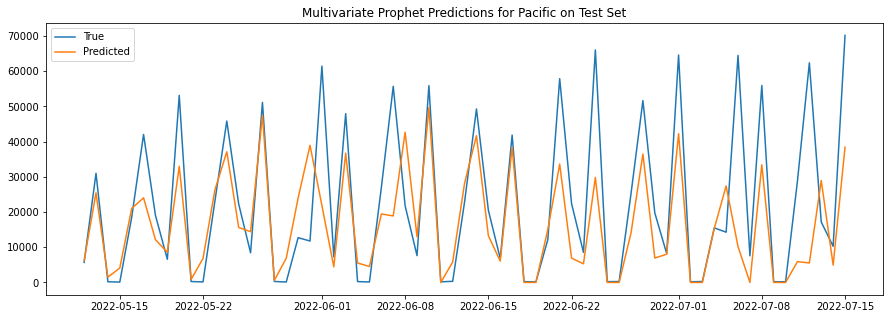


Training model for South Atlantic...


Optimization terminated abnormally. Falling back to Newton.


MAE: 10312.61
RMSE: 15005.3
MASE: 0.94


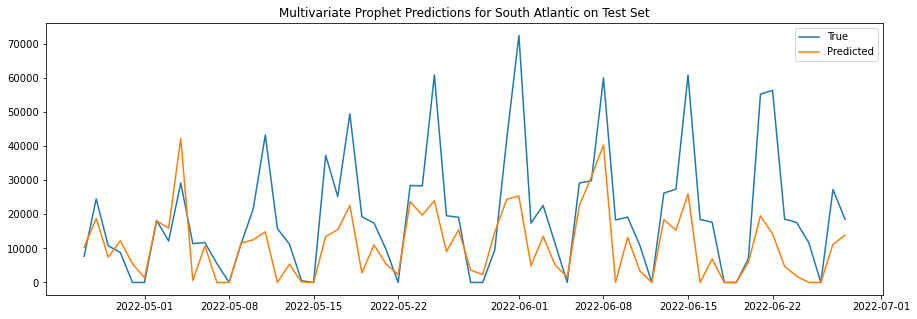


Training model for West North Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 2996.77
RMSE: 3490.04
MASE: 0.89


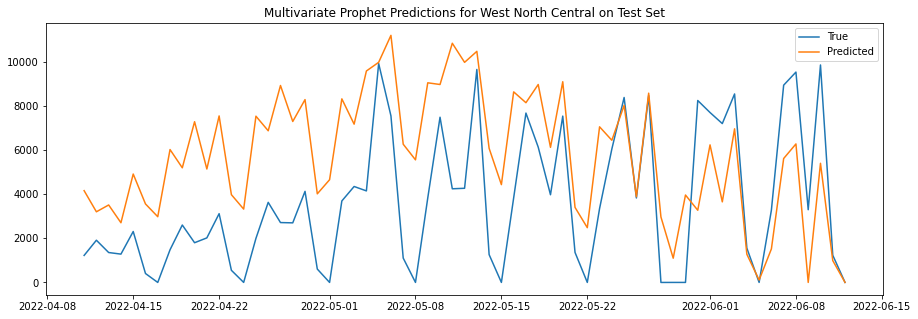


Training model for West South Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 4052.42
RMSE: 5182.72
MASE: 0.87


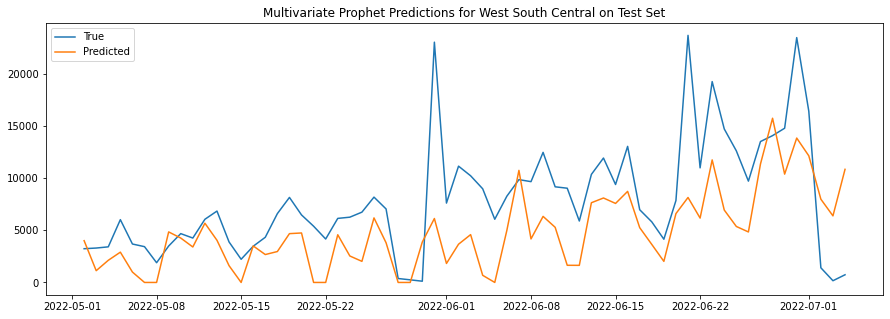


--- 30.37 seconds ---


In [130]:
start_time = time.time()
for df in datasets:
    build_multi_prophet(df, use_test=True, plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

clearly some features are creating an unnatural spike in the predictions, going to do feature selection through correlation to fi x

## Feature Selection

In [123]:
def feat2resp_correlation(df, threshold=0.5):
    region = df["region"].iloc[0]
    print(f"Correlation for {region}...")

    train, temp_test_df = train_test_split(df, test_size=0.15, shuffle=False)
    val, test  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    # test_y = test['y']
    # train = pd.concat([train_df, val])

    df = train.replace([np.nan], 0)

    features = df.columns.drop(['ds', 'y', 'region', 'location_key'], errors='ignore')

    corr = []
    for feature in features:
        pearson_corr, p_value = pearsonr(df['y'], df[feature])
        corr.append(pearson_corr)
    
    res = pd.DataFrame({'feature': features, 'correlation': corr})
    res['correlation'] = res['correlation'].abs()
    res = res.sort_values(by='correlation', ascending=False)
    cut = res[res['correlation'] > threshold]

    print(cut.shape[0], list(cut["feature"]))
    return region, list(cut["feature"])

In [125]:
first_fs = {}
for df in datasets:
    region, features = feat2resp_correlation(df, threshold=0.3)
    first_fs[region] = features
    print("")
# first_fs

Correlation for East North Central...
20 ['7_day_shift', '7_day_avg', 'new_hospitalized_patients', 'current_hospitalized_patients', '2_day_shift', '1_day_shift', 'current_intensive_care_patients', 'new_deceased', 'international_travel_controls', 'average_temperature_celsius', 'maximum_temperature_celsius', 'minimum_temperature_celsius', 'cumulative_confirmed', 'income_support', 'cumulative_hospitalized_patients', 'dew_point', 'cancel_public_events', 'cumulative_deceased', 'cumulative_vaccine_doses_administered_pfizer', 'cumulative_vaccine_doses_administered']

Correlation for East South Central...
26 ['7_day_avg', '7_day_shift', 'current_hospitalized_patients', '3_day_shift', '1_day_shift', '2_day_shift', 'new_hospitalized_patients', 'current_intensive_care_patients', 'cumulative_confirmed', 'testing_policy', 'international_travel_controls', 'cumulative_hospitalized_patients', 'cumulative_deceased', 'new_deceased', 'average_temperature_celsius', 'cumulative_vaccine_doses_administered_p

In [139]:
first_fs

{'East North Central': ['7_day_shift',
  '7_day_avg',
  'new_hospitalized_patients',
  'current_hospitalized_patients',
  '2_day_shift',
  '1_day_shift',
  'current_intensive_care_patients',
  'new_deceased',
  'international_travel_controls',
  'average_temperature_celsius',
  'maximum_temperature_celsius',
  'minimum_temperature_celsius',
  'cumulative_confirmed',
  'income_support',
  'cumulative_hospitalized_patients',
  'dew_point',
  'cancel_public_events',
  'cumulative_deceased',
  'cumulative_vaccine_doses_administered_pfizer',
  'cumulative_vaccine_doses_administered'],
 'East South Central': ['7_day_avg',
  '7_day_shift',
  'current_hospitalized_patients',
  '3_day_shift',
  '1_day_shift',
  '2_day_shift',
  'new_hospitalized_patients',
  'current_intensive_care_patients',
  'cumulative_confirmed',
  'testing_policy',
  'international_travel_controls',
  'cumulative_hospitalized_patients',
  'cumulative_deceased',
  'new_deceased',
  'average_temperature_celsius',
  'cumulat

Optimization terminated abnormally. Falling back to Newton.


Training model for East North Central...
MAE: 4203.09
RMSE: 6084.5
MASE: 0.48


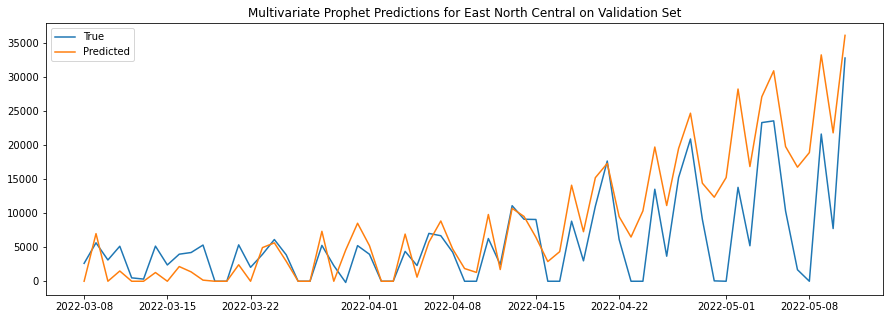


Training model for East South Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 1431.8
RMSE: 2129.72
MASE: 0.39


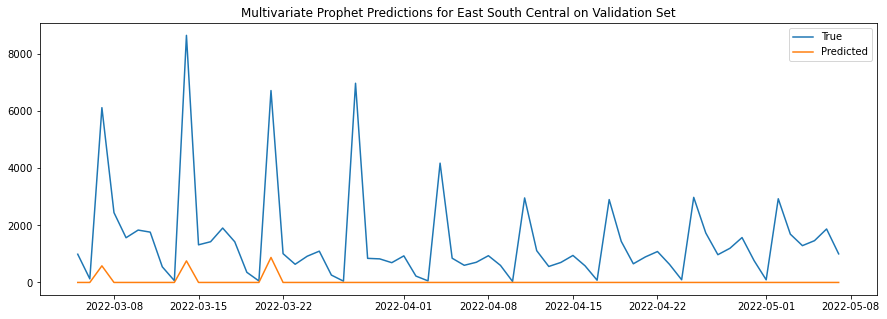


Training model for Mid-Atlantic...


Optimization terminated abnormally. Falling back to Newton.


MAE: 3554.85
RMSE: 4014.28
MASE: 1.56


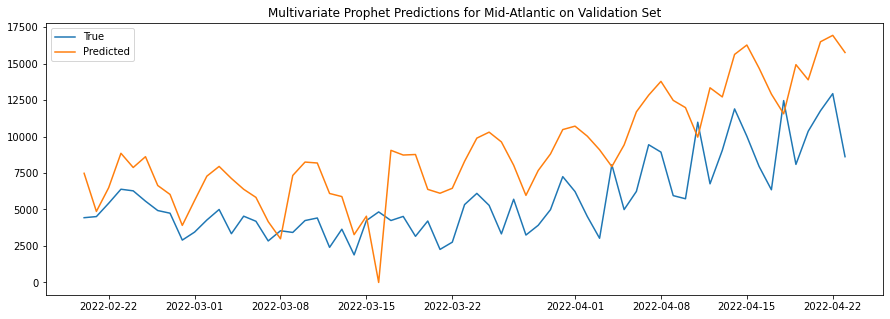


Training model for Mountain...


Optimization terminated abnormally. Falling back to Newton.


MAE: 2045.21
RMSE: 3668.81
MASE: 0.61


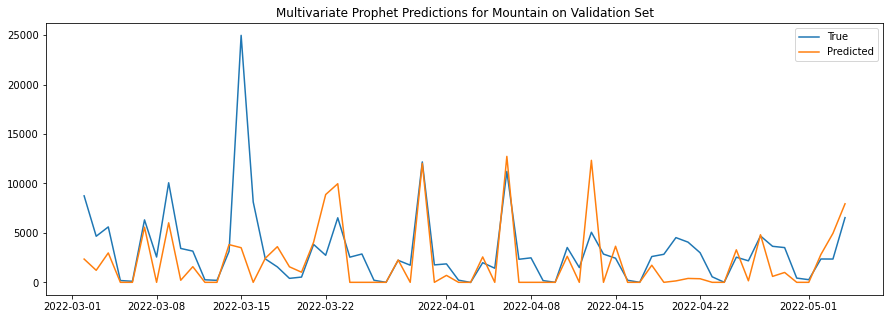


Training model for New England...


Optimization terminated abnormally. Falling back to Newton.


MAE: 2542.69
RMSE: 3362.38
MASE: 0.94


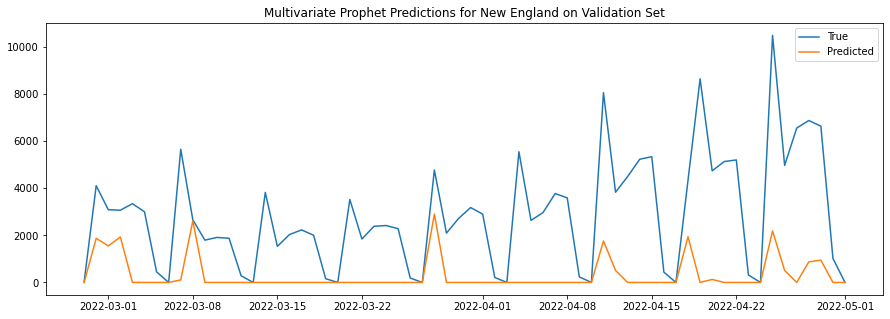


Training model for Pacific...


Optimization terminated abnormally. Falling back to Newton.


MAE: 5803.39
RMSE: 7500.99
MASE: 0.81


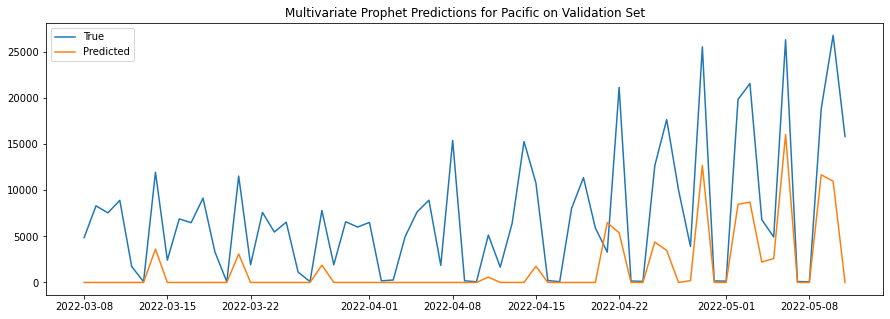


Training model for South Atlantic...


Optimization terminated abnormally. Falling back to Newton.


MAE: 5815.56
RMSE: 7174.04
MASE: 0.5


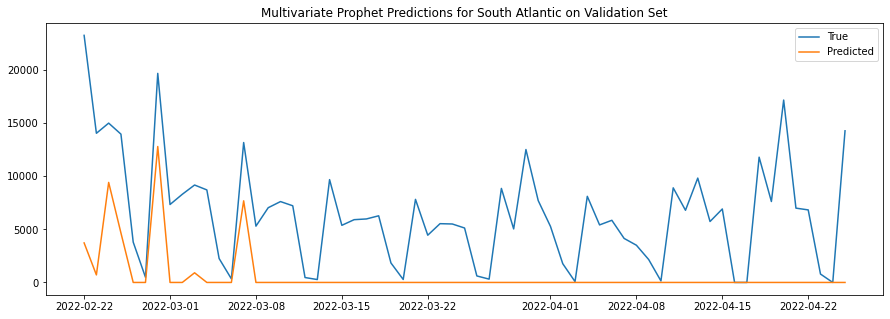


Training model for West North Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 3190.69
RMSE: 5505.55
MASE: 0.93


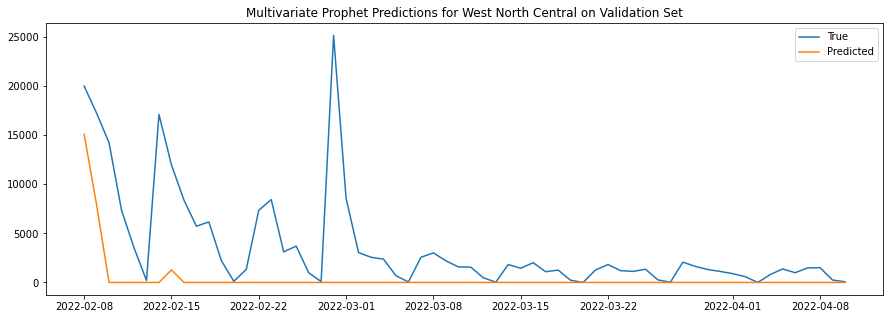


Training model for West South Central...


Optimization terminated abnormally. Falling back to Newton.


MAE: 3803.33
RMSE: 4448.15
MASE: 0.78


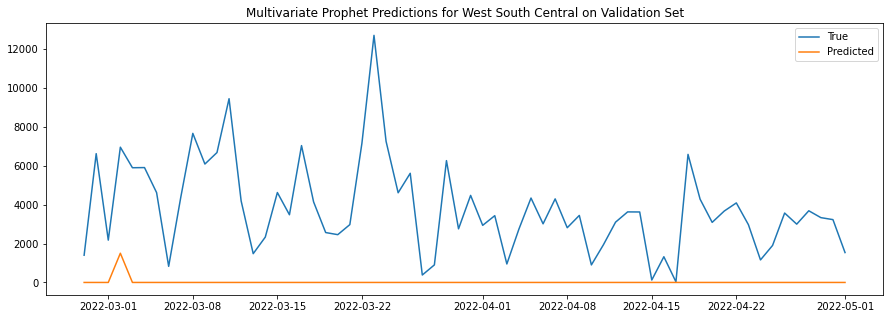


--- 21.29 seconds ---


In [131]:
start_time = time.time()
for df in datasets:
    build_multi_prophet(df, features=first_fs[df["region"].iloc[0]], plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

## Parameter Optimization

In [132]:
params_grid = {
    'changepoint_prior_scale':[0.001,0.005,0.01,0.025, 0.05, 0.1],
    'seasonality_prior_scale':[0.1,0.25,0.5,1,2,5],
    # 'yearly_seasonality': [True, 'auto'],
    # 'weekly_seasonality': [True, 'auto'],
    # 'changepoint_prior_scale': [0.01, 0.1, 0.5],
    # 'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0],
            }
grid = ParameterGrid(params_grid)
def optimize_parameters(df, features=None):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    df = df.replace([np.nan], 0)

    if features is None:
        features = df.columns.drop(['ds', 'y', 'region', 'location_key'], errors='ignore')

    train, temp_test_df = train_test_split(df, test_size=0.15, shuffle=False)
    val, test_tmp  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    val_y = val['y']
    # train = pd.concat([train_df, val])

    results = []
    for params in grid:

        model = prophet.Prophet(**params)
        model.add_country_holidays(country_name='US')
        for feature in features:
            model.add_regressor(feature, standardize=False)
        model = model.fit(train)

        # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
        pred = model.predict(val)
        pred_yhat = pred['yhat']
        pred_yhat[pred_yhat < 0] = 0

        # calculate metrics
        mae = mean_absolute_error(val_y, pred_yhat)
        rmse = mean_squared_error(val_y, pred_yhat, squared=False)
        mase = mean_absolute_scaled_error(val_y, pred_yhat, y_train=train['y'])

        results.append([params["changepoint_prior_scale"], params["seasonality_prior_scale"], mae, rmse, mase])
                
    results = pd.DataFrame(results, columns=["changepoint_prior_scale", "seasonality_prior_scale", "mae", "rmse", "mase"])
    results.sort_values(by="mase", inplace=True)
    print(results.head(1))
    return region, {"changepoint_prior_scale": results["changepoint_prior_scale"].iloc[0], "seasonality_prior_scale": results["seasonality_prior_scale"].iloc[0]}


In [133]:
# no features
start_time = time.time()
first_fs = {}
for df in datasets:
    region, tmp_params = optimize_parameters(df, features=first_fs[df["region"].iloc[0]])
    first_fs[region] = tmp_params
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")
first_fs

Training model for East North Central...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

    changepoint_prior_scale  seasonality_prior_scale          mae  \
16                     0.01                      2.0  3042.671128   

           rmse      mase  
16  4230.649622  0.350808  

Training model for East South Central...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

    changepoint_prior_scale  seasonality_prior_scale         mae         rmse  \
25                     0.05                     0.25  1404.21281  2047.799962   

        mase  
25  0.387271  

Training model for Mid-Atlantic...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

   changepoint_prior_scale  seasonality_prior_scale          mae         rmse  \
1                    0.001                     0.25  3188.169166  3644.411296   

       mase  
1  1.396633  

Training model for Mountain...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

   changepoint_prior_scale  seasonality_prior_scale          mae         rmse  \
0                    0.001                      0.1  2007.622219  3676.856997   

       mase  
0  0.600694  

Training model for New England...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

    changepoint_prior_scale  seasonality_prior_scale          mae  \
33                      0.1                      1.0  1529.358594   

           rmse      mase  
33  1975.700539  0.565057  

Training model for Pacific...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

    changepoint_prior_scale  seasonality_prior_scale          mae  \
34                      0.1                      2.0  3423.349891   

           rmse     mase  
34  4372.470925  0.47737  

Training model for South Atlantic...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

    changepoint_prior_scale  seasonality_prior_scale          mae  \
34                      0.1                      2.0  5951.515354   

           rmse     mase  
34  7343.063754  0.51335  

Training model for West North Central...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

   changepoint_prior_scale  seasonality_prior_scale          mae         rmse  \
7                    0.005                     0.25  3203.410867  5525.856205   

       mase  
7  0.933552  

Training model for West South Central...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

    changepoint_prior_scale  seasonality_prior_scale          mae  \
35                      0.1                      5.0  2541.127517   

           rmse      mase  
35  3401.393865  0.523199  

--- 1032.55 seconds ---


{'East North Central': {'changepoint_prior_scale': 0.01,
  'seasonality_prior_scale': 2.0},
 'East South Central': {'changepoint_prior_scale': 0.05,
  'seasonality_prior_scale': 0.25},
 'Mid-Atlantic': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.25},
 'Mountain': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.1},
 'New England': {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 1.0},
 'Pacific': {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 2.0},
 'South Atlantic': {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 2.0},
 'West North Central': {'changepoint_prior_scale': 0.005,
  'seasonality_prior_scale': 0.25},
 'West South Central': {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 5.0}}

In [140]:
params = {'East North Central': {'changepoint_prior_scale': 0.01,
  'seasonality_prior_scale': 2.0},
 'East South Central': {'changepoint_prior_scale': 0.05,
  'seasonality_prior_scale': 0.25},
 'Mid-Atlantic': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.25},
 'Mountain': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.1},
 'New England': {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 1.0},
 'Pacific': {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 2.0},
 'South Atlantic': {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 2.0},
 'West North Central': {'changepoint_prior_scale': 0.005,
  'seasonality_prior_scale': 0.25},
 'West South Central': {'changepoint_prior_scale': 0.1,
  'seasonality_prior_scale': 5.0}}

## Final Model

In [141]:
def build_final_multi_prophet(df, features=None, params=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    df = df.replace([np.nan], 0)

    if features is None:
        features = df.columns.drop(['ds', 'y', 'region', 'location_key'], errors='ignore')

    print(f"Num feautes: {len(features)}")

    train_df, temp_test_df = train_test_split(df, test_size=0.15, shuffle=False)
    val, test  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    test_y = test['y']
    train = pd.concat([train_df, val])

    model = prophet.Prophet(**params)
    model.add_country_holidays(country_name='US')
    for feature in features:
        model.add_regressor(feature, standardize=False)
    model = model.fit(train)

    # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
    pred = model.predict(test)
    pred_yhat = pred['yhat']
    pred_yhat[pred_yhat < 0] = 0

    # calculate metrics
    mae = mean_absolute_error(test_y, pred_yhat)
    mse = mean_squared_error(test_y, pred_yhat)
    rmse = mean_squared_error(test_y, pred_yhat, squared=False)
    mase = mean_absolute_scaled_error(test_y, pred_yhat, y_train=train['y'])

    print(f'MAE: {round(mae, 2)}')
    # print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Multivariate Prophet Predictions for {region} on Test Set')
        plt.plot(test['ds'], test_y, label='True')
        plt.plot(pred['ds'], pred_yhat, label='Predicted')
        # uncomment to show confidence interval
        # plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
        plt.legend() 
        plt.show()
    
    return region, mase, rmse, mae

Training model for East North Central...
Num feautes: 20


Optimization terminated abnormally. Falling back to Newton.


MAE: 4832.47
RMSE: 6164.81
MASE: 0.57


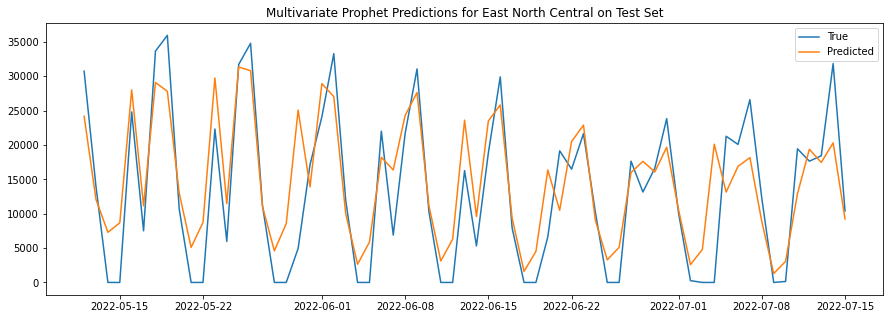


Training model for East South Central...
Num feautes: 26


Optimization terminated abnormally. Falling back to Newton.


MAE: 2768.85
RMSE: 4054.59
MASE: 0.8


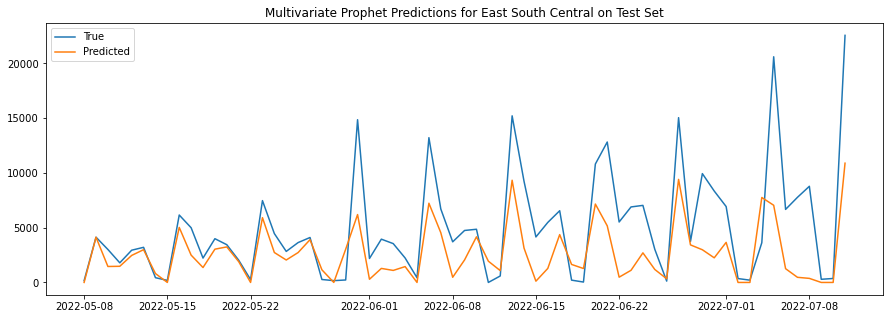


Training model for Mid-Atlantic...
Num feautes: 26


Optimization terminated abnormally. Falling back to Newton.


MAE: 5764.5
RMSE: 7870.92
MASE: 2.58


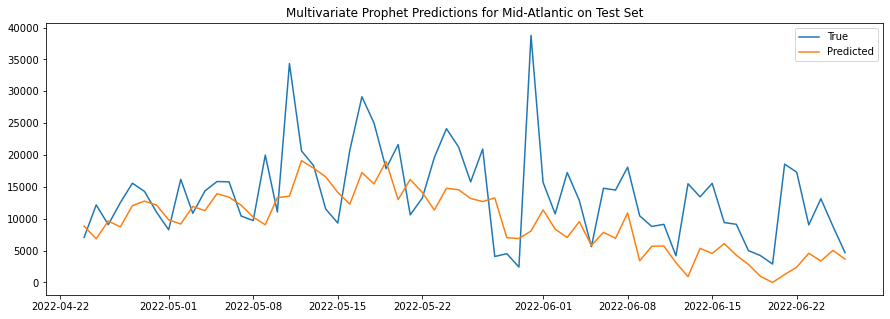


Training model for Mountain...
Num feautes: 27


Optimization terminated abnormally. Falling back to Newton.


MAE: 4672.96
RMSE: 6539.72
MASE: 1.41


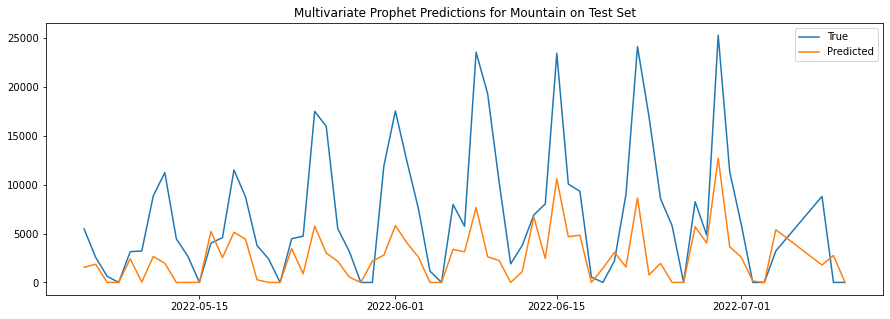


Training model for New England...
Num feautes: 19


Optimization terminated abnormally. Falling back to Newton.


MAE: 2591.81
RMSE: 3453.21
MASE: 0.98


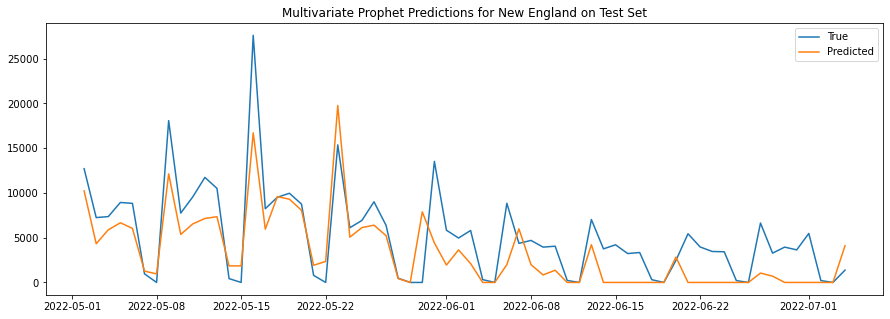


Training model for Pacific...
Num feautes: 17


Optimization terminated abnormally. Falling back to Newton.


MAE: 9954.36
RMSE: 14049.26
MASE: 1.39


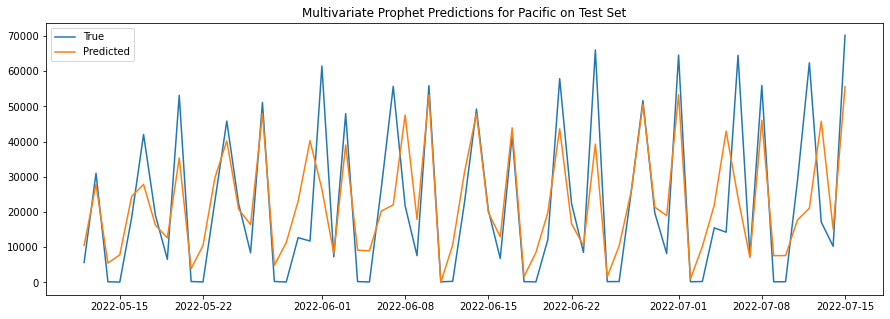


Training model for South Atlantic...
Num feautes: 23


Optimization terminated abnormally. Falling back to Newton.


MAE: 9194.66
RMSE: 11601.92
MASE: 0.84


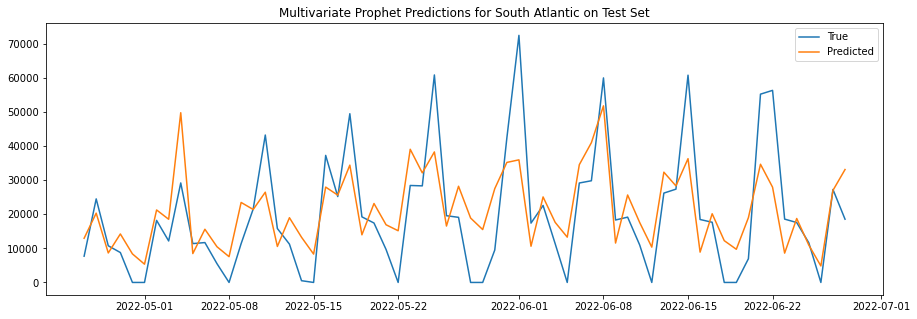


Training model for West North Central...
Num feautes: 24


Optimization terminated abnormally. Falling back to Newton.


MAE: 1726.01
RMSE: 2109.0
MASE: 0.52


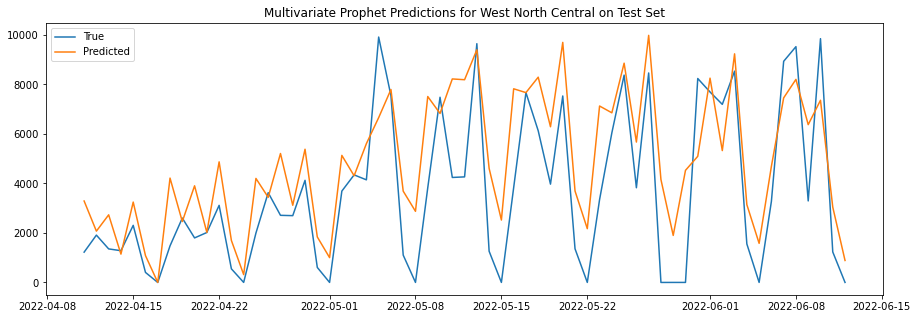


Training model for West South Central...
Num feautes: 17


Optimization terminated abnormally. Falling back to Newton.


MAE: 3820.01
RMSE: 5260.06
MASE: 0.82


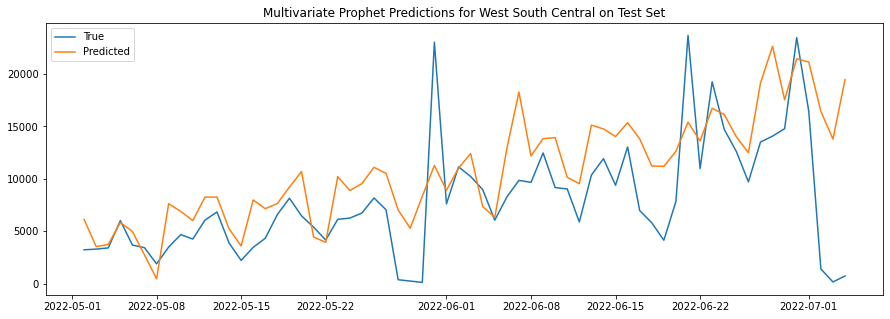


--- 59.81 seconds ---
feature selection with optimization
               region      mase          rmse          mae
0  East North Central  0.574565   6164.811456  4832.474022
1  East South Central  0.800971   4054.586827  2768.850032
2        Mid-Atlantic  2.579924   7870.922867  5764.495753
3            Mountain  1.407955   6539.723531  4672.955199
4         New England  0.979580   3453.206377  2591.814904
5             Pacific  1.388208  14049.255397  9954.364555
6      South Atlantic  0.835845  11601.924940  9194.658041
7  West North Central  0.515406   2109.004125  1726.009368
8  West South Central  0.824304   5260.058480  3820.007819


In [142]:
start_time = time.time()
results = []
for df in datasets:
    region = df["region"].iloc[0]
    region, mase, rmse, mae = build_final_multi_prophet(df, features=first_fs[region], params=params[region], plot=True)
    results.append([region, mase, rmse, mae])
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")
print("feature selection with optimization")
results = pd.DataFrame(results, columns=["region", "mase", "rmse", "mae"])
print(results)